In [1]:
import os
import numpy as np
import argparse

import pandas as pd
from sklearn.decomposition import PCA
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import umap.umap_ as umap
import time
import torch

from spiral.main import SPIRAL_integration
from spiral.layers import *
from spiral.utils import *
from spiral.CoordAlignment import CoordAlignment

R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
os.environ['R_HOME']=R_dirs
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Step1:SPIRAL integration

INPUT:

feat:ncell * ngene matrix from preprocess.ipynb

edge:nedge * 2: obtained from GenerateEdges.ipynb

meta:ncell * 1或ncell * 2,containing batch information，columns is  'batch'

In [2]:
dirs="/data02/tguo/space_batch_effect/human_DLPFC_10x/"
sample_name=np.array([151507,151508,151509,151510,151669,151670,151671,151672,151673,151674,151675,151676])
samples=sample_name[0:4]
SEP=','
net_cate='_KNN_'
rad=150
knn=6

N_WALKS=knn
WALK_LEN=1
N_WALK_LEN=knn
NUM_NEG=knn

feat_file=[]
edge_file=[]
meta_file=[]
flags=''
flags1=str(samples[0])
for i in range(1,len(samples)):
    flags1=flags1+'-'+str(samples[i])
for i in range(len(samples)):
    feat_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_features.txt")
    edge_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_edge_KNN_"+str(knn)+".csv")
    meta_file.append(dirs+"gtt_input_scanpy/"+flags1+'_'+str(samples[i])+"_label.txt")
    flags=flags+'_'+str(samples[i])
N=pd.read_csv(feat_file[0],header=0,index_col=0).shape[1]
if (len(samples)==2):
    M=1
else:
    M=len(samples)

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=0, help='The seed of initialization.')
parser.add_argument('--AEdims', type=list, default=[N,[512],32], help='Dim of encoder.')
parser.add_argument('--AEdimsR', type=list, default=[32,[512],N], help='Dim of decoder.')
parser.add_argument('--GSdims', type=list, default=[512,32], help='Dim of GraphSAGE.')
parser.add_argument('--zdim', type=int, default=32, help='Dim of embedding.')
parser.add_argument('--znoise_dim', type=int, default=4, help='Dim of noise embedding.')
parser.add_argument('--CLdims', type=list, default=[4,[],M], help='Dim of classifier.')
parser.add_argument('--DIdims', type=list, default=[28,[32,16],M], help='Dim of discriminator.')
parser.add_argument('--beta', type=float, default=1.0, help='weight of GraphSAGE.')
parser.add_argument('--agg_class', type=str, default=MeanAggregator, help='Function of aggregator.')
parser.add_argument('--num_samples', type=str, default=knn, help='number of neighbors to sample.')

parser.add_argument('--N_WALKS', type=int, default=N_WALKS, help='number of walks of random work for postive pairs.')
parser.add_argument('--WALK_LEN', type=int, default=WALK_LEN, help='walk length of random work for postive pairs.')
parser.add_argument('--N_WALK_LEN', type=int, default=N_WALK_LEN, help='number of walks of random work for negative pairs.')
parser.add_argument('--NUM_NEG', type=int, default=NUM_NEG, help='number of negative pairs.')


parser.add_argument('--epochs', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=512, help='Size of batches to train.')
parser.add_argument('--lr', type=float, default=1e-3, help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='Weight decay.')
parser.add_argument('--alpha1', type=float, default=N, help='Weight of decoder loss.')
parser.add_argument('--alpha2', type=float, default=1, help='Weight of GraphSAGE loss.')
parser.add_argument('--alpha3', type=float, default=1, help='Weight of classifier loss.')
parser.add_argument('--alpha4', type=float, default=1, help='Weight of discriminator loss.')
parser.add_argument('--lamda', type=float, default=1, help='Weight of GRL.')
parser.add_argument('--Q', type=float, default=10, help='Weight negative loss for sage losss.')

params,unknown=parser.parse_known_args()

In [4]:
SPII=SPIRAL_integration(params,feat_file,edge_file,meta_file)
SPII.train()
# if not os.path.exists(dirs+"model/"):
#     os.makedirs(dirs+"model/")
# model_file=dirs+"model/SPIRAL"+flags+"_model_"+str(SPII.params.batch_size)+".pt"
# torch.save(SPII.model.state_dict(),model_file)

--------------------------------
Training.
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 1521.55755/0.20536/2.12839/1.33688/1.33557
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 545.61744/0.07333/1.31142/1.34976/1.31386
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 526.70199/0.07080/1.11825/1.34200/1.29000
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 524.61082/0.07053/1.08209/1.34231/1.28220
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 522.15365/0.07020/1.05229/1.33986/1.27744
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 517.89795/0.06963/1.02842/1.32989/1.26829
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 519.59337/0.06986/1.01329/1.33681/1.27914
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 516.25795/0.06941/1.00043/1.33091/1.27434
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 536.64319/0.07215/1.04037/1.38334/1.32652
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 518.83261/0.06975/0.99689/1.33958/1.28586
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 513.8802

total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 495.54535/0.06661/1.01131/1.29557/1.29112
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 494.99286/0.06653/1.01281/1.29321/1.28905
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 495.97640/0.06666/1.01434/1.29436/1.29066
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 496.20257/0.06669/1.01465/1.29819/1.29411
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 492.44062/0.06619/1.00784/1.28816/1.28526
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 496.90974/0.06679/1.02146/1.30024/1.29688
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 493.68324/0.06635/1.01383/1.29013/1.28810
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 493.54563/0.06634/1.01110/1.29087/1.28905
total_loss/AE_loss/GS_loss/clas_loss/disc_loss= 493.02761/0.06627/1.01334/1.28854/1.28791


In [7]:
SPII.model.eval()
all_idx=np.arange(SPII.feat.shape[0])
all_layer,all_mapping=layer_map(all_idx.tolist(),SPII.adj,len(SPII.params.GSdims))
all_rows=SPII.adj.tolil().rows[all_layer[0]]
all_feature=torch.Tensor(SPII.feat.iloc[all_layer[0],:].values).float().cuda()
all_embed,ae_out,clas_out,disc_out=SPII.model(all_feature,all_layer,all_mapping,all_rows,SPII.params.lamda,SPII.de_act,SPII.cl_act)
[ae_embed,gs_embed,embed]=all_embed
[x_bar,x]=ae_out
embed=embed.cpu().detach()
names=['GTT_'+str(i) for i in range(embed.shape[1])]
embed1=pd.DataFrame(np.array(embed),index=SPII.feat.index,columns=names)
if not os.path.exists(dirs+"gtt_output/"):
    os.makedirs(dirs+"gtt_output/")
    
# embed_file=dirs+"gtt_output/SPIRAL"+flags+"_embed_"+str(SPII.params.batch_size)+".csv"
# embed1.to_csv(embed_file)
meta=SPII.meta.values

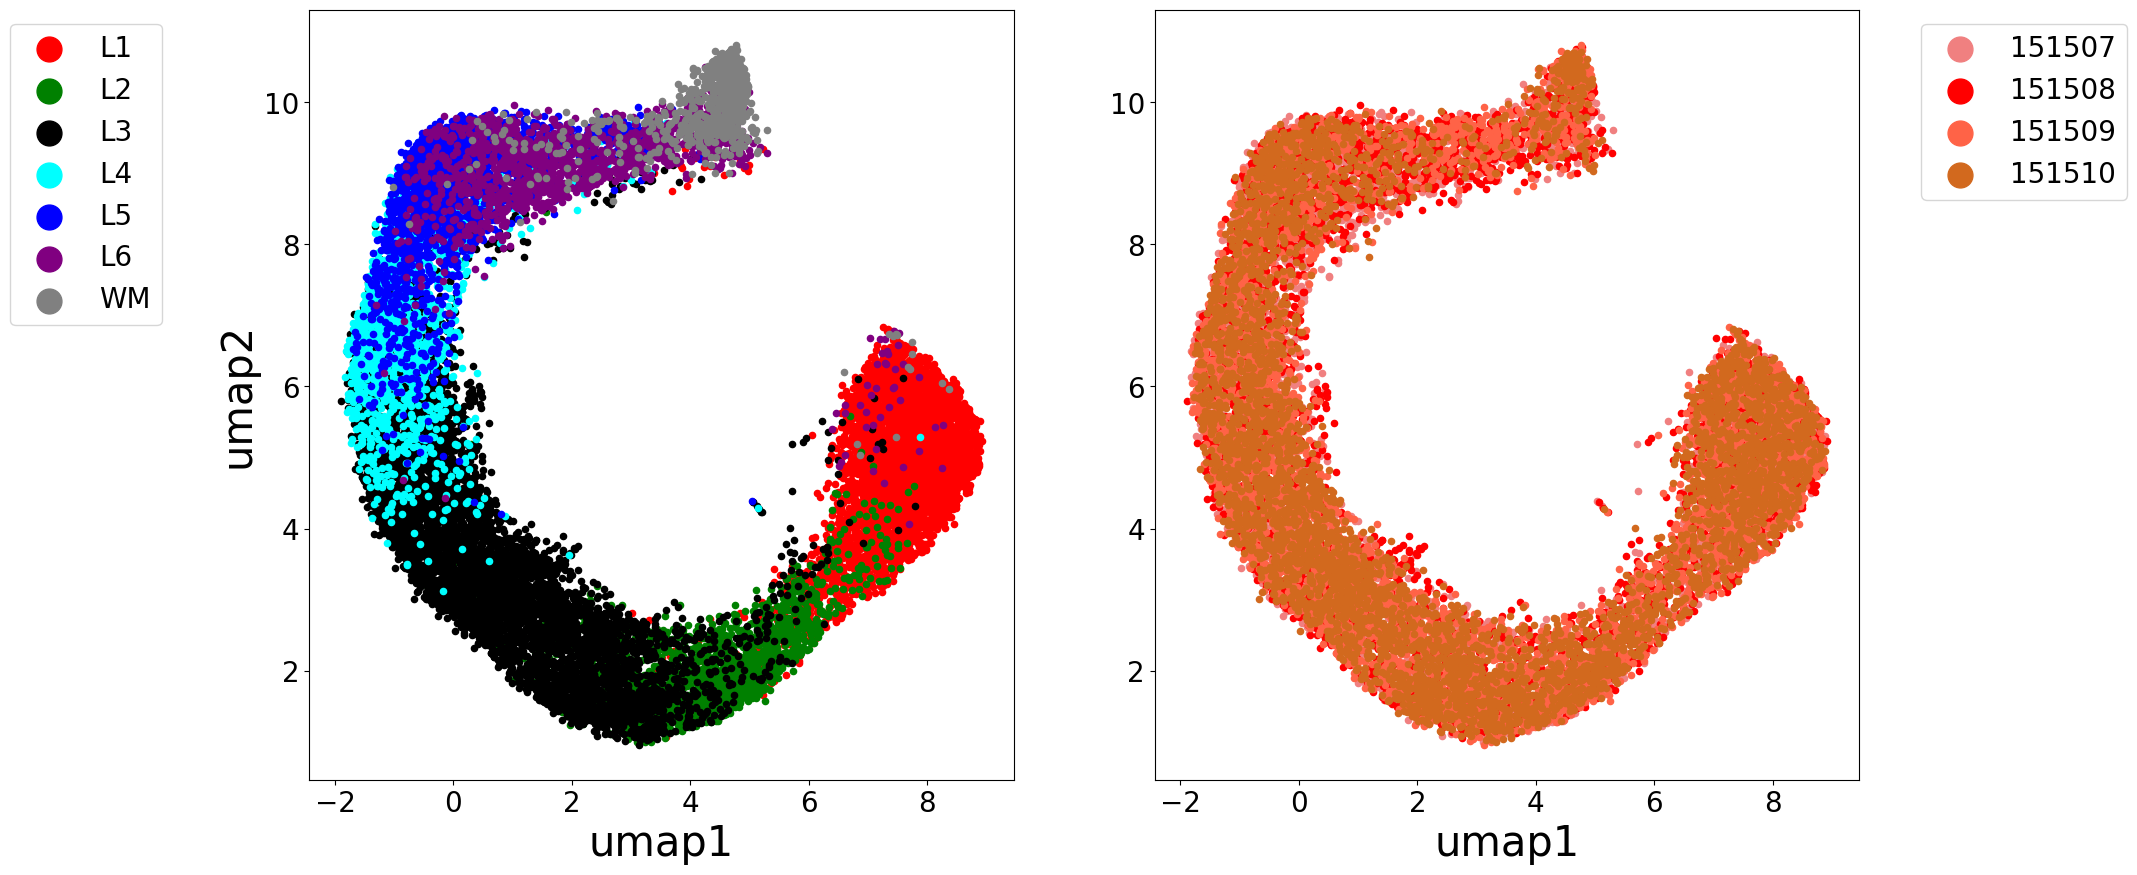

In [8]:
meta=SPII.meta.values
import umap.umap_ as umap
import matplotlib.pyplot as plt
# x=PCA(n_components=30).fit_transform(SPII.feat)
# embed=pd.read_csv(dirs+"gtt_output/AGC_embed"+flags+"_xent.csv",index_col=0,header=0).values
celltype=meta[:,0]
batch=meta[:,1]
ul=np.unique(celltype)
ub=np.unique(batch)
umap_mat=umap.UMAP().fit_transform(embed1.values[:,4:])
colour2=['r','g','black','cyan','blue','purple','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,2,figsize=(20,10))
size=20
for i in range(len(ul)):
    axs[0].scatter(umap_mat[np.where(celltype==ul[i])[0],0],umap_mat[np.where(celltype==ul[i])[0],1],c=colour2[i],s=size)

axs[0].set_xlabel("umap1",fontsize=30)
axs[0].set_ylabel("umap2",fontsize=30)
axs[0].legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs[0].tick_params(axis='both', which='major', labelsize=20)
for i in range(len(ub)):
    axs[1].scatter(umap_mat[np.where(batch==ub[i])[0],0],umap_mat[np.where(batch==ub[i])[0],1],c=colour1[i],s=size)
axs[1].set_xlabel("umap1",fontsize=30)
axs[1].legend(ub,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(1.4,1))
axs[1].tick_params(axis='both', which='major', labelsize=20)

step2: clustering

In [1]:
import anndata
import scanpy as sc
ann=anndata.AnnData(SPII.feat)
ann.obsm['spiral']=embed1.iloc[:,SPII.params.znoise_dim:].values
sc.pp.neighbors(ann,use_rep='spiral')

n_clust=7
res1=0.5 ####adjust to make sure 7 clusters
res2=0.5
sc.tl.leiden(ann,resolution=res1)
sc.tl.louvain(ann,resolution=res2)
ann = mclust_R(ann, used_obsm='spiral', num_cluster=n_clust)

ann.obs['batch']=SPII.meta.loc[:,'batch'].values
ub=np.unique(ann.obs['batch'])
sc.tl.umap(ann)
coord=pd.read_csv(coord_file[0],header=0,index_col=0)
for i in np.arange(1,len(samples)):
    coord=pd.concat((coord,pd.read_csv(coord_file[i],header=0,index_col=0)))

coord.columns=['y','x']
ann.obsm['spatial']=coord.loc[ann.obs_names,:].values
# cluster_file=dirs+"gtt_output/SPIRAL"+flags+"_louvain.csv"
# pd.DataFrame(ann.obs['louvain']).to_csv(cluster_file)

step3: smooth clusters

In [ ]:
from smooting_clustering import refine
from sklearn.metrics.pairwise import euclidean_distances
ann.obs['SPIRAL']=ann.obs['mclust']
ann.obs['SPIRAL_refine']=ann.obs['SPIRAL']
ub=np.unique(ann.obs['batch'])
for i in range(len(ub)):
    idx=np.where(ann.obs['batch']==ub[i])[0]
    ann1=ann[idx,:]
    sample_id=ann1.obs_names
    pred=ann1.obs['SPIRAL']
    dis=euclidean_distances(ann1.obsm['spatial'],ann1.obsm['spatial'])
    refined_pred=refine(sample_id, pred, dis, num_nbs=knn)
    ann.obs['SPIRAL_refine'][idx]=refined_pred
    
# cluster_file_save=dirs+"metrics/spiral"+flags+"_seuratmethod_clust_modify.csv"
# pd.DataFrame(ann.obs['SPIRAL_refine']).to_csv(cluster_file_save)

In [ ]:
# sc.pl.umap(ann,color='louvain')
# sc.pl.umap(ann,color='batch')
# sc.pl.umap(ann,color='celltype')
sc.tl.louvain(ann,resolution=1.2)
ann1=ann[ann.obs['batch']==ub[0],:]
sc.pl.spatial(ann1,color="louvain", spot_size=100)
ann1=ann[ann.obs['batch']==ub[1],:]
sc.pl.spatial(ann1,color="louvain", spot_size=100)
ann1=ann[ann.obs['batch']==ub[2],:]
sc.pl.spatial(ann1,color="louvain", spot_size=100)
ann1=ann[ann.obs['batch']==ub[3],:]
sc.pl.spatial(ann1,color="louvain", spot_size=100)

step4: SPIRAL alignment

In [ ]:
clust_cate='louvain'
input_file=[meta_file,coord_file,embed_file,cluster_file]
output_dirs=dirs+"gtt_output/SPIRAL_alignment/"
if not os.path.exists(output_dirs):
    os.makedirs(output_dirs)
ub=samples

In [ ]:
alpha=0.5
types="weighted_mean"
R_dirs="/home/tguo/tguo2/miniconda3/envs/stnet/lib/R"
CA=CoordAlignment(input_file=input_file,output_dirs=output_dirs,ub=ub,flags=flags,clust_cate=clust_cate,R_dirs=R_dirs,alpha=alpha,types=types)
New_Coord=CA.New_Coord
New_Coord.to_csv(output_dirs+"new_coord"+flags+"_rotate"+str(angle)+"_modify.csv")
# ann.obsm['aligned_spatial']=New_Coord.loc[ann.obs_names,:].values

In [ ]:
celltype=New_Coord.loc[:,'celltype']
ul=np.unique(celltype)
import matplotlib.pyplot as plt
colour2=['r','g','black','cyan','blue','purple','yellow','grey']
colour1=['lightcoral','red','tomato','chocolate','darkorange','gold','olive','yellow','yellowgreen','lawngreen','forestgreen','lime',
       'cyan','deepskyblue','dodgerblue','royalblue','blue','blueviolet','purple','fuchsia','hotpink','pink','gray','black','teal']
f, axs= plt.subplots(1,1,figsize=(10,10))
size=20
for i in range(len(ul)):
    axs.scatter(New_Coord.iloc[np.where(celltype==ul[i])[0],0],New_Coord.iloc[np.where(celltype==ul[i])[0],1],c=colour1[i],s=size)

axs.set_xlabel("umap1",fontsize=30)
axs.set_ylabel("umap2",fontsize=30)
axs.legend(ul,loc="best",fontsize=20,markerscale=4,bbox_to_anchor=(-0.19,1))
axs.tick_params(axis='both', which='major', labelsize=20)